In [66]:
# required imports
from vivarium.plots.simulation_output import _save_fig_to_dir as save_fig_to_dir
import ast
import cobra
from cobra import io
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from vivarium.plots.topology import plot_topology

In [67]:
# Define the path to the SBML model file
model_path = "../vivarium_microbiome/data/Alteromonas_Model.xml"
#model_path = "../vivarium_microbiome/data/e_coli_core.xml"

In [68]:
# Load the model
model = io.read_sbml_model(model_path)

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


In [69]:
# 1. Number of all reactions
total_reactions = len(model.reactions)
print(f"Total number of reactions: {total_reactions}")

Total number of reactions: 881


In [70]:
# 2. Number of exchange fluxes
exchange_reactions = [reaction for reaction in model.reactions if reaction.id.startswith('EX_')]
num_exchange_fluxes = len(exchange_reactions)
print(f"Number of exchange fluxes: {num_exchange_fluxes}")

Number of exchange fluxes: 62


In [71]:
# Extract and print human-friendly information for exchange reactions
exchange_reactions = [reaction for reaction in model.reactions if reaction.id.startswith('EX_')]
print("Human-friendly exchange reactions information:")
for reaction in exchange_reactions:
    # Format the bounds in a readable way
    bounds = f"[{reaction.lower_bound}, {reaction.upper_bound}]"
    
    # Print the details
    #print(f"ID: {reaction.id}, Name: {reaction.name}, Bounds: {bounds}")

Human-friendly exchange reactions information:


In [72]:
# Optional: Specify the reaction ID for which you want to find the name
reaction_id_to_find = "EX_cpd00033_e0"

# Find the reaction by its ID and print its name
for reaction in model.reactions:
    if reaction.id == reaction_id_to_find:
        print(f"The name of the reaction with ID '{reaction_id_to_find}' is: '{reaction.name}'")
        break
else:
    print(f"No reaction found with the ID '{reaction_id_to_find}'")

The name of the reaction with ID 'EX_cpd00033_e0' is: 'Exchange for Glycine_e0'


In [73]:
# Optional: Dictionary for exchange fluxes: ID as key, Name as value
name_exchange_fluxes_dict = {reaction.id: reaction.name for reaction in model.reactions if reaction.id.startswith('EX_')}

#print(exchange_fluxes_dict)

In [74]:
# Dictionary for exchange fluxes: ID as key, Bounds as value
bound_exchange_fluxes_dict = {reaction.id: f"[{reaction.lower_bound}, {reaction.upper_bound}]" 
                        for reaction in model.reactions if reaction.id.startswith('EX_')}

# Adding an empty key and value
new_key = "None"  # This is an example key. 
bound_exchange_fluxes_dict[new_key] = "None"

# Print the dictionary
#print(bound_exchange_fluxes_dict)

In [75]:
# Import the FBA class and the main function from the Fba_process.py file
sys.path.append('../vivarium_microbiome/processes/Altrmns/')
from Fba import FBA, main

In [76]:
# Function to process model with setting the bound to a given flux_id as zero
def process_model(model_path, flux_id, flux_name):
    if flux_id == "None":
        output, processes, topology = main(model_path)
    else:
        reaction_id = flux_id  # Assuming the key itself is the reaction ID
        bounds = [0, 0]  # Set bounds to zero
        output, processes, topology = main(model_path, reaction_id, bounds)
        print(f"Set {flux_name} as zero. Flux ID: {flux_id}")

    return output

In [77]:
# Function to extract flux data from output
def extract_flux_data(output):
    if isinstance(output, str):
        output = ast.literal_eval(output)
    flux_data = output[1]['fluxes_values']
    return flux_data

In [78]:
# Function to sort and print flux details
def sort_and_print_fluxes(flux_data, flux_type):
    sorted_fluxes = sorted(flux_data.items(), key=lambda item: item[1])
    num_fluxes = len(sorted_fluxes)
    print(f"Number of {flux_type} Fluxes: {num_fluxes}")

    print(f"\n{flux_type} Fluxes:")
    for key, value in sorted_fluxes:
        print(f'{key}: {value}')

In [80]:
def ex_bar_chart(flux_data, flux_name, ex_output_folder, bar_colors, objective_flux, objective_flux_label):
    sorted_fluxes = sorted(flux_data.items(), key=lambda item: item[0])
    keys, values = zip(*sorted_fluxes)

    plt.figure(figsize=(12, 6))

    # Plot the regular flux bars
    plt.bar(keys, values, color=bar_colors)

    # Add a white (or transparent) bar for spacing
    plt.bar(len(keys), 0, color='white', width=0.5)

    # Add the objective flux bar separately at the end, in red
    plt.bar(len(keys) + 1, objective_flux, color='red', width=0.5)

    plt.xlabel('Exchange Fluxes')
    plt.ylabel('Flux Value')
    plt.title(f'Exchange Fluxes when {flux_name} is zero')
    plt.xticks(list(range(len(keys) + 2)), list(keys) + ['', objective_flux_label], rotation=90)

    plt.tight_layout()

    file_name = f"Ex_{flux_name}_zero_with_objective.png"
    file_path = os.path.join(ex_output_folder, file_name)
    plt.savefig(file_path)
    plt.close()


In [81]:
def main_loop(model_path, bound_exchange_fluxes_dict, name_exchange_fluxes_dict, ex_output_folder):
    for flux_id, _ in bound_exchange_fluxes_dict.items():
        flux_name = name_exchange_fluxes_dict.get(flux_id, "No Reaction")
        output = process_model(model_path, flux_id, flux_name)
        flux_data = extract_flux_data(output)

        if isinstance(output, str):
            output = ast.literal_eval(output)
        objective_flux = output[1]['objective_flux_value']
        print(f"Objective flux for when eliminate '{flux_id}' ({flux_name}): {objective_flux}")

        bar_colors = ['orange' if objective_flux <= 0 else 'blue' for _ in flux_data]

        exchange_fluxes = {key: value for key, value in flux_data.items() if key.startswith('EX_')}
        uptake_fluxes = {key: value for key, value in exchange_fluxes.items() if value < 0}
        secretion_fluxes = {key: value for key, value in exchange_fluxes.items() if value > 0}

        sort_and_print_fluxes(uptake_fluxes, "Uptake")
        sort_and_print_fluxes(secretion_fluxes, "Secretion")
        ex_bar_chart(exchange_fluxes, flux_name, ex_output_folder, bar_colors, objective_flux, "Objective Flux")



# Specify the ex_output folder
ex_output_folder = "/Users/amin/Desktop/Microbiome/vivarium_microbiome/output/ex"

# Ensure the ex_output folder exists
os.makedirs(ex_output_folder, exist_ok=True)


ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 034b5624-995d-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 21:12:06
Completed in 0.043004 seconds
Set Exchange for Cu2+_e0 as zero. Flux ID: EX_cpd00058_e0
Objective flux for when eliminate 'EX_cpd00058_e0' (Exchange for Cu2+_e0): 0.0
Number of Uptake Fluxes: 4

Uptake Fluxes:
EX_cpd00033_e0: -1.4761506276150624
EX_cpd00027_e0: -0.527196652719665
EX_cpd00054_e0: -0.15815899581589965
EX_cpd00067_e0: -0.10543933054393466
Number of Secretion Fluxes: 4

Secretion Fluxes:
EX_cpd00075_e0: 0.15815899581589962
EX_cpd00001_e0: 0.4744769874476987
EX_cpd00047_e0: 0.6853556485355647
EX_cpd00161_e0: 1.4761506276150627


ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 0401384a-995d-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 21:12:07
Completed in 0.064096 seconds
Set Exchange for L-Tryptophan_e0 as zero. Flux ID: EX_cpd00065_e0
Objective flux for when eliminate 'EX_cpd00065_e0' (Exchange for L-Tryptophan_e0): 77.52628444824518
Number of Uptake Fluxes: 38

Uptake Fluxes:
EX_cpd00132_e0: -991.1825410742846
EX_cpd00023_e0: -738.2145057703125
EX_cpd00027_e0: -567.5722340325143
EX_cpd00033_e0: -264.4822258024725
EX_cpd00007_e0: -213.74360293601669
EX_cpd00009_e0: -62.99524914689372
EX_cpd00107_e0: -29.102502573094835
EX_cpd00156_e0: -27.307330409629852
EX_cpd00142_e0: -26.549992073034318
EX_cpd00039_e0: -22.128949168865653
EX_cpd00054_e0: -19.986556548288156
EX_cpd00051_e0: -19.12548804922247
EX_cpd00322_e0: -18.745740091566432
EX_cpd00129_e0: -14.29233222450859
EX_cpd00066_e0: -11.979321936967837
EX_cpd00060_e0: -9.907969440662189
EX_cpd03847_e0: -9.69489356177714
EX_cpd01080_e0: -9.658331485179893
EX_cpd00069_e0: -9.573159868194143
EX

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 05061580-995d-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 21:12:09
Completed in 0.064751 seconds
Set Exchange for Fe-enterochlin_e0 as zero. Flux ID: EX_cpd03726_e0
Objective flux for when eliminate 'EX_cpd03726_e0' (Exchange for Fe-enterochlin_e0): 78.54889337399587
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00132_e0: -994.7738930702296
EX_cpd00023_e0: -741.630028473323
EX_cpd00027_e0: -563.1088069548878
EX_cpd00033_e0: -306.9713450328153
EX_cpd00007_e0: -209.41237626732632
EX_cpd00009_e0: -63.82618673815166
EX_cpd00107_e0: -29.486378559216636
EX_cpd00156_e0: -27.66752721274058
EX_cpd00142_e0: -26.90019921975526
EX_cpd00039_e0: -22.42084063636752
EX_cpd00051_e0: -19.377762422071196
EX_cpd00322_e0: -18.993005406470512
EX_cpd00054_e0: -16.542530314218297
EX_cpd00129_e0: -14.480854950789103
EX_cpd00066_e0: -12.137334946676337
EX_cpd00060_e0: -10.038660316127144
EX_cpd03847_e0: -9.822773864064747
EX_cpd01080_e0: -9.785729516117355
EX_cpd00069_e0: -9.69943444459782

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 05bceee0-995d-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 21:12:10
Completed in 0.062788 seconds
Set Exchange for L-Lysine_e0 as zero. Flux ID: EX_cpd00039_e0
Objective flux for when eliminate 'EX_cpd00039_e0' (Exchange for L-Lysine_e0): 78.15924475211277
Number of Uptake Fluxes: 41

Uptake Fluxes:
EX_cpd00041_e0: -652.1595590377409
EX_cpd00027_e0: -580.1473876062703
EX_cpd00132_e0: -342.64025859074985
EX_cpd00007_e0: -298.69089269857363
EX_cpd00033_e0: -65.3285620022428
EX_cpd00009_e0: -63.509571383878054
EX_cpd00023_e0: -44.47936694499902
EX_cpd00107_e0: -29.340108812102343
EX_cpd00156_e0: -27.53028003602954
EX_cpd00142_e0: -26.76675844033584
EX_cpd00051_e0: -19.281637345082682
EX_cpd00322_e0: -18.898788950144265
EX_cpd00161_e0: -16.497285381894812
EX_cpd00054_e0: -16.460469652857938
EX_cpd00129_e0: -14.409021409502236
EX_cpd00066_e0: -12.077126640331544
EX_cpd00060_e0: -9.988862667939951
EX_cpd03847_e0: -9.77404713941213
EX_cpd01080_e0: -9.737186553176794
EX_cpd000

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 067d9b40-995d-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 21:12:11
Completed in 0.061818 seconds
Set Exchange for L-Isoleucine_e0 as zero. Flux ID: EX_cpd00322_e0
Objective flux for when eliminate 'EX_cpd00322_e0' (Exchange for L-Isoleucine_e0): 77.94540826080924
Number of Uptake Fluxes: 40

Uptake Fluxes:
EX_cpd00041_e0: -665.2846092194255
EX_cpd00027_e0: -576.9333214061382
EX_cpd00132_e0: -310.68235202374626
EX_cpd00007_e0: -279.52603168750386
EX_cpd00033_e0: -100.4490630109985
EX_cpd00009_e0: -63.335815048942884
EX_cpd00023_e0: -44.35767549579019
EX_cpd00107_e0: -29.259836978069885
EX_cpd00156_e0: -27.45495972675353
EX_cpd00142_e0: -26.693527055787484
EX_cpd00039_e0: -22.248583040264236
EX_cpd00051_e0: -19.228884562100497
EX_cpd00054_e0: -16.41543532471238
EX_cpd00129_e0: -14.369599654710457
EX_cpd00066_e0: -12.04408473474523
EX_cpd00060_e0: -9.961534060148779
EX_cpd03847_e0: -9.747306247112624
EX_cpd01080_e0: -9.71054650804454
EX_cpd00069_e0: -9.624914434929781
EX

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 0749f096-995d-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 21:12:12
Completed in 0.067622 seconds
Set Exchange for Enterobactin_e0 as zero. Flux ID: EX_cpd03453_e0
Objective flux for when eliminate 'EX_cpd03453_e0' (Exchange for Enterobactin_e0): 78.54889337399587
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00132_e0: -994.7738930702296
EX_cpd00023_e0: -741.630028473323
EX_cpd00027_e0: -563.1088069548878
EX_cpd00033_e0: -306.9713450328153
EX_cpd00007_e0: -209.41237626732632
EX_cpd00009_e0: -63.82618673815166
EX_cpd00107_e0: -29.486378559216636
EX_cpd00156_e0: -27.66752721274058
EX_cpd00142_e0: -26.90019921975526
EX_cpd00039_e0: -22.42084063636752
EX_cpd00051_e0: -19.377762422071196
EX_cpd00322_e0: -18.993005406470512
EX_cpd00054_e0: -16.542530314218297
EX_cpd00129_e0: -14.480854950789103
EX_cpd00066_e0: -12.137334946676337
EX_cpd00060_e0: -10.038660316127144
EX_cpd03847_e0: -9.822773864064747
EX_cpd01080_e0: -9.785729516117355
EX_cpd00069_e0: -9.699434444597827
EX

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 08371376-995d-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 21:12:14
Completed in 0.065393 seconds
Set Exchange for PAN_e0 as zero. Flux ID: EX_cpd00644_e0
Objective flux for when eliminate 'EX_cpd00644_e0' (Exchange for PAN_e0): 78.5091326862455
Number of Uptake Fluxes: 38

Uptake Fluxes:
EX_cpd00132_e0: -994.3359202312508
EX_cpd00023_e0: -741.4452099989957
EX_cpd00027_e0: -563.3787374541532
EX_cpd00033_e0: -306.0576644873757
EX_cpd00007_e0: -209.58796023653295
EX_cpd00009_e0: -63.79387854164548
EX_cpd00107_e0: -29.47145284046462
EX_cpd00156_e0: -28.09414042249195
EX_cpd00142_e0: -26.886582599893945
EX_cpd00039_e0: -22.409491424362727
EX_cpd00051_e0: -19.36795358673476
EX_cpd00322_e0: -18.983391331402487
EX_cpd00054_e0: -16.534156645867643
EX_cpd00129_e0: -14.473524882504917
EX_cpd00066_e0: -12.131191145481854
EX_cpd00060_e0: -10.033578843669458
EX_cpd03847_e0: -9.817801671234578
EX_cpd01080_e0: -9.780776074776718
EX_cpd00069_e0: -9.694524684985163
EX_cpd00084_e0: -6.8

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 08ef78e4-995d-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 21:12:15
Completed in 0.048422 seconds
Set Exchange for O2_e0 as zero. Flux ID: EX_cpd00007_e0
Objective flux for when eliminate 'EX_cpd00007_e0' (Exchange for O2_e0): 1.3273756461473248e-30
Number of Uptake Fluxes: 32

Uptake Fluxes:
EX_cpd00033_e0: -1.4761506276150627
EX_cpd00027_e0: -0.5271966527196651
EX_cpd00054_e0: -0.15815899581589954
EX_cpd00067_e0: -0.10543933054393674
EX_cpd00119_e0: -1.4129967928566383e-16
EX_cpd00053_e0: -1.412996792856634e-16
EX_cpd00011_e0: -1.0520163070959244e-16
EX_cpd00132_e0: -2.6457891612235355e-30
EX_cpd00107_e0: -4.982820140600757e-31
EX_cpd00156_e0: -4.675457569650286e-31
EX_cpd00039_e0: -3.788834768831647e-31
EX_cpd00142_e0: -3.6518304126732207e-31
EX_cpd00051_e0: -3.274593544356845e-31
EX_cpd00322_e0: -3.209574538963479e-31
EX_cpd00066_e0: -2.0510540792271167e-31
EX_cpd00060_e0: -1.6808639776818152e-31
EX_cpd00069_e0: -1.6018318601456685e-31
EX_cpd00084_e0: -1.0197866307

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 09a55038-995d-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 21:12:16
Completed in 0.068187 seconds
Set Exchange for Na+_e0 as zero. Flux ID: EX_cpd00971_e0
Objective flux for when eliminate 'EX_cpd00971_e0' (Exchange for Na+_e0): 78.54889337399587
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00132_e0: -994.7738930702296
EX_cpd00023_e0: -741.630028473323
EX_cpd00027_e0: -563.1088069548878
EX_cpd00033_e0: -306.9713450328153
EX_cpd00007_e0: -209.41237626732632
EX_cpd00009_e0: -63.82618673815166
EX_cpd00107_e0: -29.486378559216636
EX_cpd00156_e0: -27.66752721274058
EX_cpd00142_e0: -26.90019921975526
EX_cpd00039_e0: -22.42084063636752
EX_cpd00051_e0: -19.377762422071196
EX_cpd00322_e0: -18.993005406470512
EX_cpd00054_e0: -16.542530314218297
EX_cpd00129_e0: -14.480854950789103
EX_cpd00066_e0: -12.137334946676337
EX_cpd00060_e0: -10.038660316127144
EX_cpd03847_e0: -9.822773864064747
EX_cpd01080_e0: -9.785729516117355
EX_cpd00069_e0: -9.699434444597827
EX_cpd00084_e0: -6.8

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 0a6dc16c-995d-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 21:12:18
Completed in 0.065460 seconds
Set Exchange for L-Asparagine_e0 as zero. Flux ID: EX_cpd00132_e0
Objective flux for when eliminate 'EX_cpd00132_e0' (Exchange for L-Asparagine_e0): 78.31996346643766
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00041_e0: -994.7891245028355
EX_cpd00027_e0: -562.6334280858257
EX_cpd00033_e0: -313.54972977054865
EX_cpd00053_e0: -297.94840573097025
EX_cpd00007_e0: -208.56290856013527
EX_cpd00009_e0: -63.640166001211924
EX_cpd00107_e0: -29.400440825050886
EX_cpd00156_e0: -27.58689050132311
EX_cpd00142_e0: -26.82179887754603
EX_cpd00039_e0: -22.355495336723102
EX_cpd00051_e0: -19.321286141255275
EX_cpd00322_e0: -18.93765049585143
EX_cpd00054_e0: -16.494317286982106
EX_cpd00129_e0: -14.438650654295428
EX_cpd00066_e0: -12.101960814107517
EX_cpd00060_e0: -10.009402748267629
EX_cpd03847_e0: -9.794145494955094
EX_cpd01080_e0: -9.757209112362613
EX_cpd00069_e0: -9.67116554690379

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 0b580bdc-995d-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 21:12:19
Completed in 0.065599 seconds
Set Exchange for L-Alanine_e0 as zero. Flux ID: EX_cpd00035_e0
Objective flux for when eliminate 'EX_cpd00035_e0' (Exchange for L-Alanine_e0): 72.49350358802342
Number of Uptake Fluxes: 41

Uptake Fluxes:
EX_cpd00067_e0: -1000.0
EX_cpd00041_e0: -929.7006368221182
EX_cpd00033_e0: -920.5673957903978
EX_cpd00023_e0: -668.0576378361551
EX_cpd00007_e0: -240.9944637501706
EX_cpd00027_e0: -185.40485897577628
EX_cpd00009_e0: -58.905780827238196
EX_cpd00107_e0: -27.213252766054175
EX_cpd00156_e0: -25.534617957234648
EX_cpd00142_e0: -24.82644382233221
EX_cpd00039_e0: -20.69240216256309
EX_cpd00051_e0: -17.88391700165364
EX_cpd00322_e0: -17.528821176711062
EX_cpd00054_e0: -15.267254943731414
EX_cpd00132_e0: -14.558928822645834
EX_cpd00129_e0: -13.364515593293666
EX_cpd00066_e0: -11.201659205006855
EX_cpd00060_e0: -9.264772887138262
EX_cpd03847_e0: -9.065529274466662
EX_cpd01080_e0: -

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 0c0f8e74-995d-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 21:12:20
Completed in 0.038039 seconds
Set Exchange for Folate_e0 as zero. Flux ID: EX_cpd00393_e0
Objective flux for when eliminate 'EX_cpd00393_e0' (Exchange for Folate_e0): 0.0
Number of Uptake Fluxes: 4

Uptake Fluxes:
EX_cpd00033_e0: -1.4761506276150624
EX_cpd00027_e0: -0.527196652719665
EX_cpd00054_e0: -0.15815899581589965
EX_cpd00067_e0: -0.10543933054393466
Number of Secretion Fluxes: 4

Secretion Fluxes:
EX_cpd00075_e0: 0.15815899581589962
EX_cpd00001_e0: 0.4744769874476987
EX_cpd00047_e0: 0.6853556485355647
EX_cpd00161_e0: 1.4761506276150627


ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 0cc0513c-995d-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 21:12:22
Completed in 0.042099 seconds
Set Exchange for Ca2+_e0 as zero. Flux ID: EX_cpd00063_e0
Objective flux for when eliminate 'EX_cpd00063_e0' (Exchange for Ca2+_e0): 0.0
Number of Uptake Fluxes: 4

Uptake Fluxes:
EX_cpd00033_e0: -1.4761506276150624
EX_cpd00027_e0: -0.527196652719665
EX_cpd00054_e0: -0.15815899581589965
EX_cpd00067_e0: -0.10543933054393466
Number of Secretion Fluxes: 4

Secretion Fluxes:
EX_cpd00075_e0: 0.15815899581589962
EX_cpd00001_e0: 0.4744769874476987
EX_cpd00047_e0: 0.6853556485355647
EX_cpd00161_e0: 1.4761506276150627


ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 0d808ad8-995d-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 21:12:23
Completed in 0.081242 seconds
Set Exchange for Heme_e0 as zero. Flux ID: EX_cpd00028_e0
Objective flux for when eliminate 'EX_cpd00028_e0' (Exchange for Heme_e0): 78.40607089308315
Number of Uptake Fluxes: 38

Uptake Fluxes:
EX_cpd00132_e0: -993.4632760186989
EX_cpd00023_e0: -742.7038349558211
EX_cpd00027_e0: -563.3402801760552
EX_cpd00033_e0: -298.45810549201286
EX_cpd00007_e0: -210.7796675680181
EX_cpd00009_e0: -63.71013399764554
EX_cpd00107_e0: -29.432764592703986
EX_cpd00156_e0: -27.617220394814712
EX_cpd00142_e0: -26.85128760528706
EX_cpd00039_e0: -22.380073670134298
EX_cpd00051_e0: -19.342528569819706
EX_cpd00322_e0: -18.958471143343147
EX_cpd00054_e0: -16.512451657237083
EX_cpd00129_e0: -14.454524960118226
EX_cpd00066_e0: -12.115266089760691
EX_cpd00060_e0: -10.020407399888555
EX_cpd03847_e0: -9.804913485993849
EX_cpd01080_e0: -9.767936494382749
EX_cpd00069_e0: -9.681798329926776
EX_cpd00084_e0:

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 0e428f66-995d-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 21:12:24
Completed in 0.064877 seconds
Set Exchange for ocdca_e0 as zero. Flux ID: EX_cpd01080_e0
Objective flux for when eliminate 'EX_cpd01080_e0' (Exchange for ocdca_e0): 78.46352992523914
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00132_e0: -994.7795725711358
EX_cpd00023_e0: -741.5485616210419
EX_cpd00027_e0: -566.8415854755243
EX_cpd00033_e0: -291.3779660984468
EX_cpd00007_e0: -210.29871510132855
EX_cpd00009_e0: -63.75682327307535
EX_cpd00107_e0: -29.454334072565796
EX_cpd00156_e0: -27.637459372953142
EX_cpd00142_e0: -26.870965277951544
EX_cpd00039_e0: -22.39647466253219
EX_cpd00051_e0: -19.356703530488087
EX_cpd00322_e0: -18.97236465172389
EX_cpd00054_e0: -16.524552626969918
EX_cpd00129_e0: -14.465117800752434
EX_cpd00066_e0: -12.12414463010713
EX_cpd00060_e0: -10.02775074593878
EX_cpd03847_e0: -9.8120989096844
EX_cpd00214_e0: -9.775094819889123
EX_cpd00069_e0: -9.688893530020733
EX_cpd00084_e0: -6

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 0f2efc0c-995d-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 21:12:26
Completed in 0.043029 seconds
Set Exchange for Sulfate_e0 as zero. Flux ID: EX_cpd00048_e0
Objective flux for when eliminate 'EX_cpd00048_e0' (Exchange for Sulfate_e0): 0.0
Number of Uptake Fluxes: 4

Uptake Fluxes:
EX_cpd00033_e0: -1.4761506276150627
EX_cpd00027_e0: -0.5271966527196654
EX_cpd00054_e0: -0.15815899581589948
EX_cpd00067_e0: -0.10543933054393173
Number of Secretion Fluxes: 6

Secretion Fluxes:
EX_cpd03847_e0: 1.4439219430427661e-16
EX_cpd00011_e0: 1.4439219430427666e-16
EX_cpd00075_e0: 0.15815899581589946
EX_cpd00001_e0: 0.4744769874476995
EX_cpd00047_e0: 0.6853556485355651
EX_cpd00161_e0: 1.4761506276150627


ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 0fe32d6c-995d-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 21:12:27
Completed in 0.044309 seconds
Set Exchange for Niacin_e0 as zero. Flux ID: EX_cpd00218_e0
Objective flux for when eliminate 'EX_cpd00218_e0' (Exchange for Niacin_e0): 0.0
Number of Uptake Fluxes: 4

Uptake Fluxes:
EX_cpd00033_e0: -1.4761506276150627
EX_cpd00027_e0: -0.5271966527196654
EX_cpd00054_e0: -0.15815899581589948
EX_cpd00067_e0: -0.10543933054393173
Number of Secretion Fluxes: 6

Secretion Fluxes:
EX_cpd03847_e0: 1.4439219430427661e-16
EX_cpd00011_e0: 1.4439219430427666e-16
EX_cpd00075_e0: 0.15815899581589946
EX_cpd00001_e0: 0.4744769874476995
EX_cpd00047_e0: 0.6853556485355651
EX_cpd00161_e0: 1.4761506276150627


ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 1095dafc-995d-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 21:12:28
Completed in 0.064153 seconds
Set Exchange for S-Adenosyl-L-methionine_e0 as zero. Flux ID: EX_cpd00017_e0
Objective flux for when eliminate 'EX_cpd00017_e0' (Exchange for S-Adenosyl-L-methionine_e0): 78.47645647550652
Number of Uptake Fluxes: 38

Uptake Fluxes:
EX_cpd00132_e0: -994.9989299539111
EX_cpd00023_e0: -741.5608981113742
EX_cpd00027_e0: -563.0464768341166
EX_cpd00033_e0: -305.88510284991264
EX_cpd00007_e0: -209.56031091906476
EX_cpd00009_e0: -63.767326952708466
EX_cpd00107_e0: -29.45918655537334
EX_cpd00156_e0: -27.64201253297777
EX_cpd00142_e0: -26.875392161163774
EX_cpd00039_e0: -22.40016439145227
EX_cpd00051_e0: -19.359892469367534
EX_cpd00322_e0: -18.97549027232234
EX_cpd00054_e0: -16.52727498040446
EX_cpd00129_e0: -14.46750087060997
EX_cpd00066_e0: -12.12614203406231
EX_cpd00060_e0: -10.249620204603154
EX_cpd03847_e0: -9.813715413427031
EX_cpd01080_e0: -9.776705227357127
EX_cpd00069_e0: 

KeyboardInterrupt: 

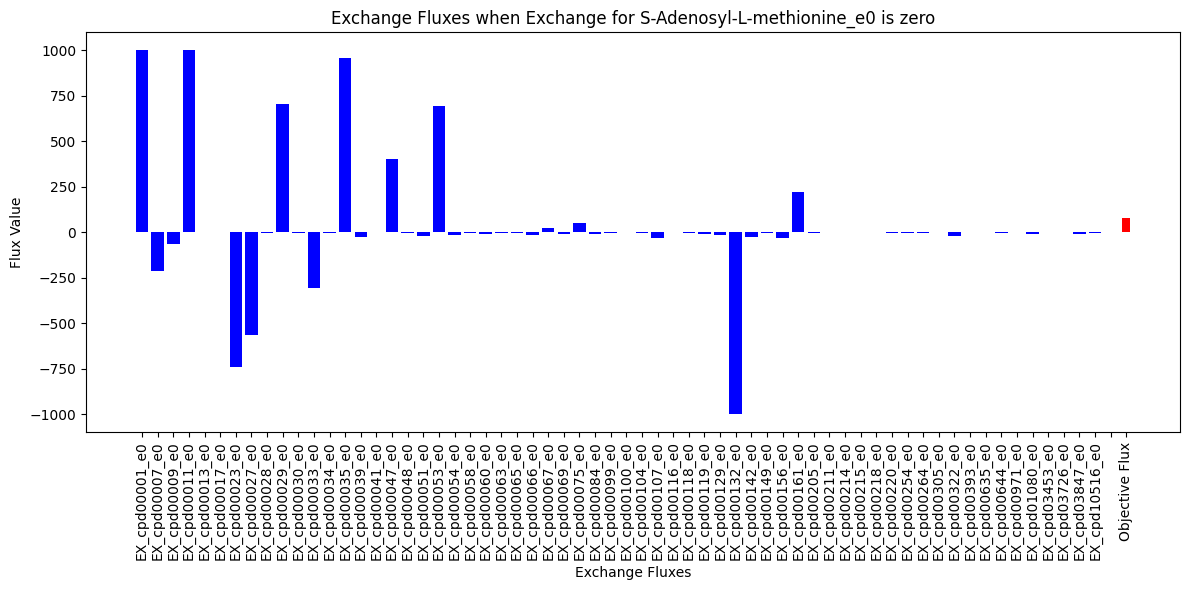

In [82]:
# Call the main loop
main_loop(model_path, bound_exchange_fluxes_dict, name_exchange_fluxes_dict, ex_output_folder)

## Model Topology. 
#### The model compute the FBA and provide the optimized Fluxes, the Objective flux and the reactions. 

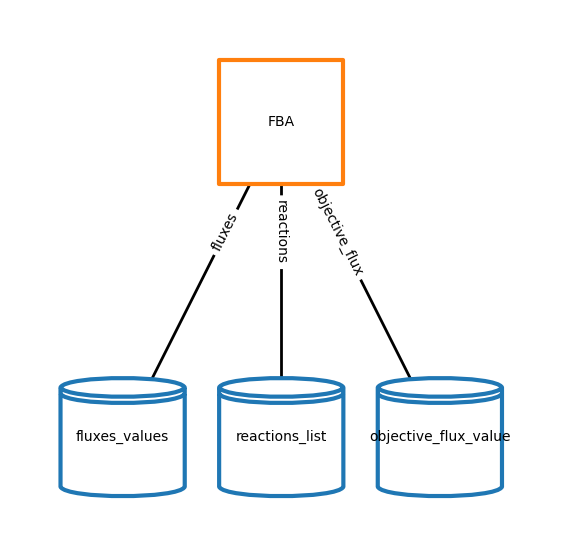

In [29]:
composite = {'processes' : processes , 'topology' : topology , 'steps' : {}, 'flow' : {}}
config ={'font_size' : 10}
fig_topology = plot_topology(composite, config)
